# Example of using The Module Formerly Known as KDE and Asy_peakbag
This is a notebook showing a rough draft of the replacement module for KDE and Asy_peakbag, which is currently WIP on the PBjam-dev branch.

We'll start by importing the modeID sampler (Should the name be changed?)

In [49]:
%load_ext autoreload
%autoreload 2
from pbjam.modeID import modeIDsampler
from pbjam import IO

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We'll also use the IO module to load the PSD. This is a new module that contains all I/O related matters, saving/loading/downloading etc. The largest part of this is wrapping the various lightkurve steps to getting a PSD. However it now also stores lightkurve search results so that cached data are loaded more quickly. 

The IO.psd class also normalizes the PSD consistently (Parseval). This is important now that we're working on the PSD and not the SNR spectrum.

In [50]:
psd = IO.psd('KIC10963065', lk_kwargs={'quarter': (6), 'exptime': 60, 'mission':'Kepler', 'author':'Kepler'})

psd()

f = psd.freq[::2]

s = psd.powerdensity[::2]

Using cached search result.
Loading fits files from cache.


## Priors
With the update to PBjam most of the parameters are included in the dimensionality reduction (DR). The latent parameter priors are constructed by the DR module, using the the prior sample of the model parameters. For the g-mode parameters the prior sample is not even remotely complete however. To get around this we can supply the modeID class with a list of priors for these parameters. They will then automatically be removed from the list of parameters included in the DR.

These priors are all in the form of class instances of distributions, similar to the scipy.stats classes. However, here we're using a set of custom classes that have been jaxed.

In [51]:
import pbjam.distributions as dist

addPriors = {'nurot_c': dist.uniform(loc=-2.1, scale=1.1) # Core rotation rate in log(muHz)
            }

These location and scale parameters for the priros are suitable for a cool MS star. The g-mode parameters are of course non-sense, and all fits to MS stars just recover this prior since the p-modes can't feel any of the g-modes yet. For lower numax targets, the prior parameters must be chosen by hand (see the bottom of this notebook).

The pbjam.distributions module contains a short list of 'standard' distributions,these include normal, uniform, beta and a few others.. The jax.scipy.stats module could replace some of these functions, but they are far from complete (many don't have a ppf method for example). If you want to construct your own distribution you can do so, although it must have a ppf method which is required by Dynesty.

If you wish to add a distribution as a prior, you'll need to use the correct keyword as everything is now keyword-based rather than index-based. You can view a list of all keywords for the model parameters, whether they are treated in log10 or not and whether they are included in the DR by default in the `modeIDsampler.variables` attribute of the sampler class. You can edit this before initializing the class below in case you want to set a parameter to log10, but you won't need to edit things if you're just adding priors. This will be handled automatically. **Ideally you won't need to edit this at all**

Apart from those listed above, the shot noise and the very lowest frequency harvey law have hardcoded priors. It's safe to ignore these for now. 

## Additional observational parameters
As in the earlier PBjam versions we use additional observational parameters. $\nu_{max}$, $\Delta\nu$ and $T_{eff}$ are used to select the prior sub-sample to construct the covariance matrix for DR, while $T_{eff}$ and $G_{bp}-G_{rp}$ are used in the actual sampling as additional log-likelihood terms.

In [52]:
# addObs = {'numax': (3600, 10),
#           'dnu'  : (150, 0.54),
#           'teff' : (5271, 142),
#           'bp_rp': (0.970026, 0.05),
#           }

addObs = {'numax': (2204, 100),
          'dnu'  : (103.2, 0.54),
          'teff' : (6140, 77),
          'bp_rp': (0.70026, 0.05),
          }

## Initialize the sampler
We can now initialize the sampler class. This requires specifying the number of orders `N_p` (previously `norders`) to include in the model. In addition we also set the number of targets (`N_pca`) to draw from the prior sample to construct covariance matrix for DR, and the number of dimensions (`PCAdims`) to use in the sampling.  

TODO: add in a check that `PCAdims` + non-PCA dims <= all model parameters.

In [53]:
N_p = 7

N_pca = 100

PCAdims = 8
 
M = modeIDsampler(f, s, addObs, addPriors, N_p=N_p, Npca=N_pca, PCAdims=PCAdims, priorpath=IO.get_priorpath())

## Plot the prior
It's always good to check that your prior is reasonable, so lets plot some samples from the prior.

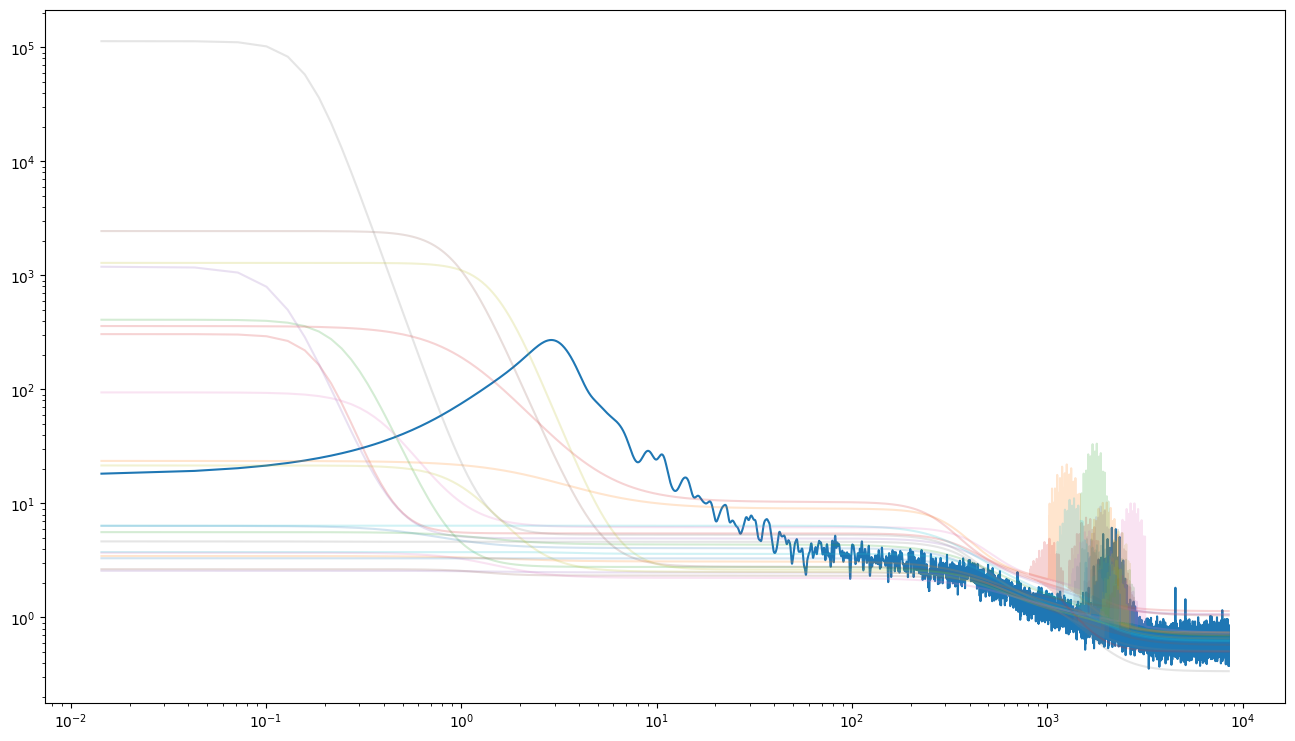

In [54]:
import matplotlib.pyplot as plt
import astropy.convolution as conv
import numpy as np

fac = max([1, 0.5 / (M.f[1] - M.f[0])])
kernel = conv.Gaussian1DKernel(stddev=np.array(fac))
smoo = conv.convolve(M.s, kernel)

N = 20

fig, ax = plt.subplots(figsize=(16,9))

ax.loglog(M.f, smoo)

for i in range(N):
    u = np.random.uniform(0, 1, size=M.ndims)

    theta = M.ptform(u)

    theta_u = M.unpackParams(theta)
    
    m = M.model(theta_u, M.f)
    
    ax.loglog(M.f, m, alpha = 0.2)

## Run Dynesty
Time to run! You can optionally run with the dynamic sampler enabled, but it probably won't do you much good and take an order of magnitude longer.

In [55]:
sampler, samples = M(nlive=200)

11834it [21:29,  9.18it/s, +200 | bound: 378 | nc: 1 | ncall: 385686 | eff(%):  3.122 | loglstar:   -inf < -167203.486 <    inf | logz: -167260.996 +/-  0.518 | dlogz:  0.001 >  0.209]


## Plot model samples
Time to plot some of the posterior samples

(0.0, 20.0)

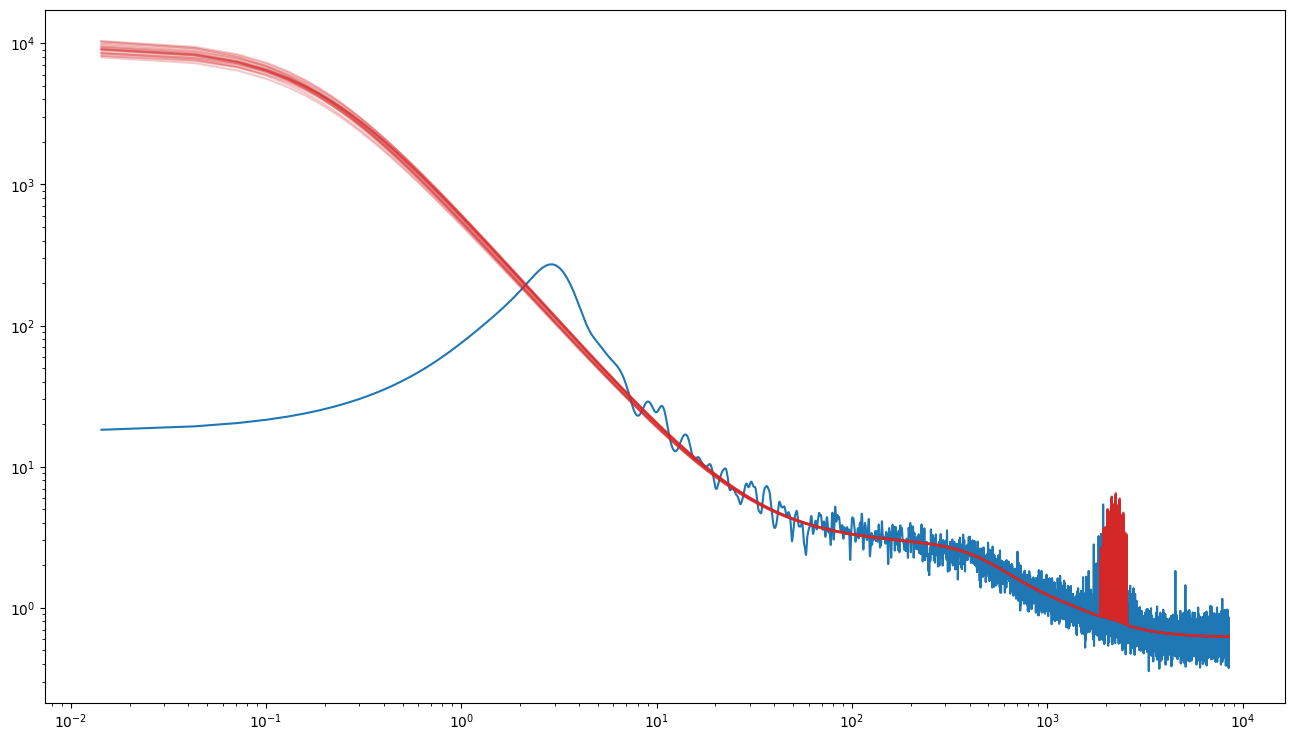

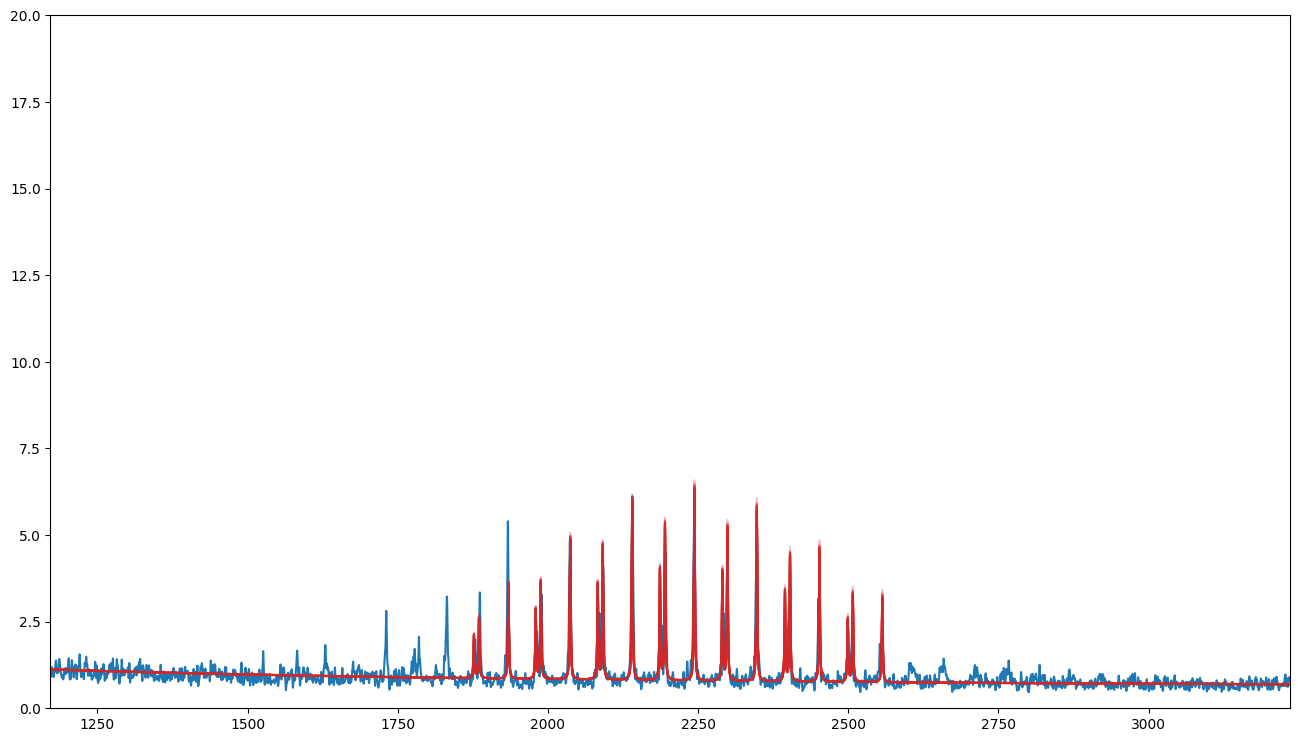

In [56]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(M.f, smoo)
 
N = 20
for i in np.random.randint(0, samples.shape[0], size=N):
    
    theta = samples[i, :]

    theta_u = M.unpackParams(theta)
     
    m = M.model(theta_u, M.f)
    
    ax.plot(M.f, m, color='C3', alpha=0.25)
    
ax.set_yscale('log')
ax.set_xscale('log')


fig, ax = plt.subplots(figsize=(16,9))
ax.plot(M.f, smoo)
 
N = 20
for i in np.random.randint(0, samples.shape[0], size=N):
    
    theta = samples[i, :]

    theta_u = M.unpackParams(theta)
     
    m = M.model(theta_u, M.f)
    
    ax.plot(M.f, m, color='C3', alpha=0.25)
ax.set_xlim(addObs['numax'][0]-10*addObs['dnu'][0], addObs['numax'][0]+10*addObs['dnu'][0])
ax.set_ylim(0, 20)

## Corner plot
We can make a nice corner plot too. However, the samples from the priors contain a mix of latent parameters and model parameters, some in log10, others not. To get everything in terms of linear model parameters we'll need to transform the raw samples

In [ ]:
samples_u = M.unpackSamples(samples)

In [ ]:
import corner
corner.corner(samples_u);

Or any subset.

In [ ]:
corner.corner({k : samples_u[k] for k in ['dnu', 'numax', 'd01', 'd02', 'eps_p']});

## Parameters for other stars

In [ ]:
# # KIC8524425
# obs = {'teff': (5413, 80),
#        'bp_rp': (0.9026, 0.05), 
#        'numax': (1084.7, 10.0),
#        'dnu': (59.62, 0.21)}


##############
# OUT OF DATE - NEED TO LOG ALL THESE VALUES
##############
# # These parameters are suitable for a cool subgiant at ~1000 muHz.
# addPriors = {'p_L0': dist.normal(loc=0.024, scale=0.1 * 0.024), # First coefficient of coupling strength matrix poly.
#              'p_D0': dist.normal(loc=0.0036, scale=0.1 * 0.0036), # First coefficient of overlap integral matrix poly.
#              'DPi0': dist.normal(loc=0.000476, scale=0.1 * 0.000476), # period spacing in 1/muHz (mega seconds)
#              'eps_g': dist.normal(loc=0.81, scale=0.1 *0.81), # epsilon for g-modes
#              'alpha_g': dist.normal(loc=0.02, scale=0.002), # curvature for g-modes
#              'd01': dist.normal(loc=26, scale=2.6), # absolute l=0,1 spacing in muHz.
#              'nurot_c': dist.uniform(loc=0.01, scale=.05) # Core rotation rate in log(muHz)
#             }


 
       
       